In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes
from time import time

from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

properati = pd.read_csv('datos/caba_para_mapa.csv',error_bad_lines=False)

<IPython.core.display.Javascript object>

In [7]:
properati.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48323 entries, 0 to 48322
Data columns (total 26 columns):
created_on                    48323 non-null object
property_type                 48323 non-null object
place_name                    48323 non-null object
state_name                    48323 non-null object
lat-lon                       48323 non-null object
lat                           48323 non-null float64
lon                           48323 non-null float64
price                         48323 non-null float64
currency                      48323 non-null object
price_aprox_local_currency    48323 non-null float64
price_aprox_usd               48323 non-null float64
surface_total_in_m2           48323 non-null float64
surface_covered_in_m2         48323 non-null float64
price_usd_per_m2              48323 non-null float64
price_per_m2                  48323 non-null float64
floor                         6223 non-null float64
rooms                         33792 non-null float

In [8]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])
properati['anio'] = [x.year for x in properati['created_on'] ]

In [9]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=properati['place_name']
le_barrio.fit(barrios)
properati['place_name'] = le_barrio.transform(barrios)

le_divisa = preprocessing.LabelEncoder()
divisa=properati['currency']
le_divisa.fit(divisa)
properati['currency'] = le_divisa.transform(divisa)

le_tipo = preprocessing.LabelEncoder()
tipos_prop=properati['property_type']
le_tipo.fit(tipos_prop)
properati['property_type'] = le_tipo.transform(tipos_prop)

In [22]:
#preparo set de datos
X = zip(       properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'])
y = properati['price_aprox_usd']

### Busco hiper-parametros con random search

In [23]:
%%notify

estimator = GaussianMixture()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"init_params": ["kmeans", "random"]}

search = RandomizedSearchCV(estimator, param_distributions=param_grid ,cv=5,n_iter=2,n_jobs=-1) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 30.10 segundos para 2 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: -11.324 (std: 0.333)
Promedio validation score: -13.086 (std: 2.823)
Promedio fit time: 0.047s
Hiper-parametros: {'init_params': 'kmeans'}

Puesto: 1
Promedio training score: -11.324 (std: 0.333)
Promedio validation score: -13.086 (std: 2.823)
Promedio fit time: 0.031s
Hiper-parametros: {'init_params': 'random'}



<IPython.core.display.Javascript object>

In [24]:
search.score(X_test,y_test) # pruebo el estimador refiteado con el set de test

-10.645543673078134

In [25]:
mejor = search.best_estimator_
errores = mejor.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:8000000.0
Error minimo:4250.0
28311    -597000.0
41380    -375000.0
11157    -269000.0
32653     -81500.0
36838    -160000.0
13173    -105000.0
20827     -80000.0
4285    -1200000.0
35519    -128000.0
46285   -1400000.0
33105    -240000.0
28042    -210000.0
27351    -143000.0
17314    -110000.0
18132    -295000.0
18241     -65969.0
41378    -170000.0
36495    -103350.0
17504    -240000.0
48160    -129000.0
15633    -420000.0
3469     -190000.0
10154    -498000.0
27471    -369000.0
27123    -130000.0
42984    -279600.0
9924     -117000.0
32974    -470000.0
37118    -800000.0
39839    -120000.0
           ...    
18347    -104000.0
1749      -29558.0
9417     -365000.0
32991    -225000.0
33894     -78000.0
3124     -345000.0
4702     -209000.0
16864     -71000.0
48052     -78000.0
22623     -79000.0
354     -1500000.0
25214    -225000.0
47741    -210000.0
4336      -33200.0
21335    -280000.0
32994    -227000.0
36231    -120000.0
42071    -230000.0
14497    -119000.0
4795   

### Analsis de errores

In [26]:
count_max=0
max_error=1000
lista=[]
for error in errores:
    if abs(error)>=max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de de {1} que tienen mas de {2} USD de error".format(count_max,len(errores),max_error))

Hay 9665 de de 9665 que tienen mas de 1000 USD de error


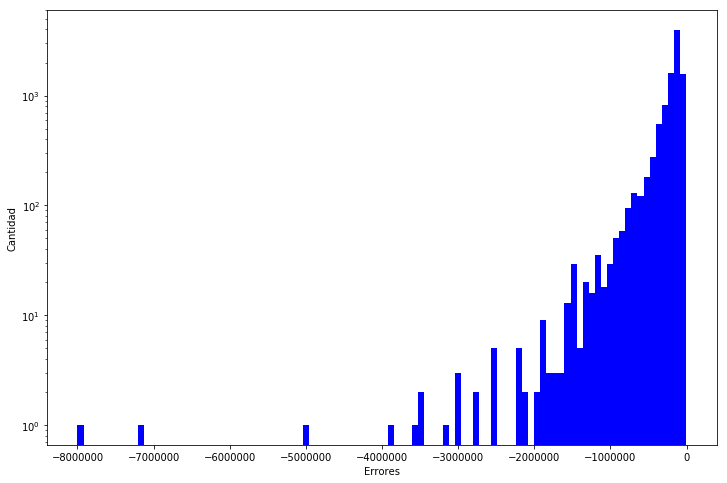

In [27]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 100, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-1000, 1000) #para variar el "zoom a 0"
plt.yscale('log')
plt.show()